In [1]:
import SimpleITK as sitk
import numpy as np
import copy
import bm3d

import pandas as pd 
import cv2
import sklearn
import csv

import matplotlib.pyplot as plt
import math

import skimage
import os
from skimage import exposure
from scipy.ndimage import zoom
import glob

import tensorflow as tf 

In [2]:
def load_data(start=0, finish=1000):
    """
    Loading the data
    """
    
    csvlines = readCsv('d:/Licenta/CSV/Train/trainNodules_gt.csv')
    header = csvlines[0]
    nodules = csvlines[1:]
    
    
    volumes = []
    masks = []
    index = 0
    
    for n in nodules:
        vol = float(n[header.index('Volume')])
        if nodEqDiam(vol)>3 and (index >= start and index <= finish):
            lnd = int(n[header.index('LNDbID')])
            finding = int(n[header.index('FindingID')])
            rad = list(map(int,list(n[header.index('RadID')].split(','))))
            masks.append(np.load(glob.glob('d:/Licenta/masks/mask_cubes/LNDb-{:04d}_finding{}_rad{}.npy'.format(lnd,finding,rad))[0]))
            volumes.append(np.load(glob.glob('d:/Licenta/Train/train_cubes/LNDb-{:04d}_finding{}_rad{}.npy'.format(lnd,finding,rad))[0]))
            index += 1
                
    return volumes, masks

In [191]:
volumes, masks = load_data()

In [9]:
def plot_lung(patient , no_slice):
    """
    :param patient:(int) The number of the patient
    :param no_slice:(int) The slice which we'll plot
    
    Showing the nodule and the lung image
    """
    fig, ax = plt.subplots(1,2, figsize=[15, 15])
    volume = volumes[patient][no_slice]
    mask = masks[patient][no_slice]


    ax[0].set_title("Lung")
    ax[0].imshow(volume, cmap='gray')
    ax[0].axis('off')
    ax[1].set_title("Nodule")
    ax[1].imshow(mask,cmap='gray')
    ax[1].axis('off')
    plt.show()

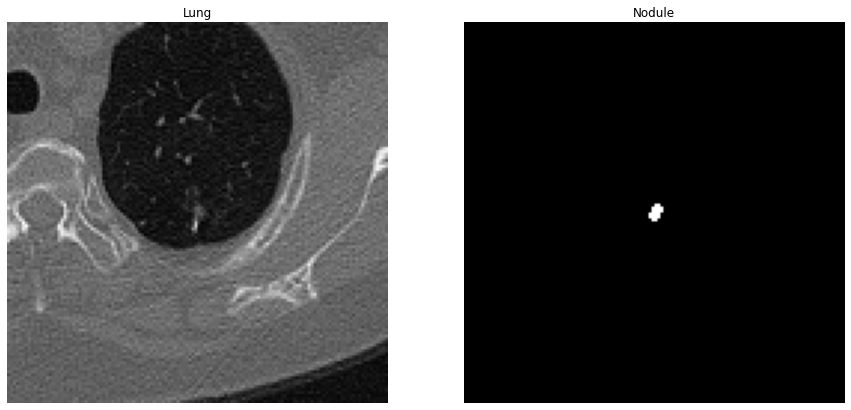

In [186]:
plot_lung(5, 64)

In [3]:
def extractCube(scan,spacing,xyz,cube_size=128,cube_size_mm=128):
    # Extract cube of cube_size^3 voxels and world dimensions of cube_size_mm^3 mm from scan at image coordinates xyz
    xyz = np.array([xyz[i] for i in [2,1,0]],np.int)
    spacing = np.array([spacing[i] for i in [2,1,0]])
    scan_halfcube_size = np.array(cube_size_mm/spacing/2,np.int)
    if np.any(xyz<scan_halfcube_size) or np.any(xyz+scan_halfcube_size>scan.shape): # check if padding is necessary
        maxsize = max(scan_halfcube_size)
        scan = np.pad(scan,((maxsize,maxsize,)),'constant',constant_values=0)
        xyz = xyz+maxsize
    
    scancube = scan[xyz[0]-scan_halfcube_size[0]:xyz[0]+scan_halfcube_size[0], # extract cube from scan at xyz
                    xyz[1]-scan_halfcube_size[1]:xyz[1]+scan_halfcube_size[1],
                    xyz[2]-scan_halfcube_size[2]:xyz[2]+scan_halfcube_size[2]]

    sh = scancube.shape
    scancube = zoom(scancube,(cube_size/sh[0],cube_size/sh[1],cube_size/sh[2]),order=2) #resample for cube_size
    
    return scancube

def readCsv(csvfname):
    # read csv to list of lists
    with open(csvfname, 'r') as csvf:
        reader = csv.reader(csvf)
        csvlines = list(reader)
    return csvlines

def writeCsv(csfname,rows):
    # write csv from list of lists
    with open(csfname, 'w', newline='') as csvf:
        filewriter = csv.writer(csvf)
        filewriter.writerows(rows)
        
def readMhd(filename):
    # read mhd/raw image
    itkimage = sitk.ReadImage(filename)
    scan = sitk.GetArrayFromImage(itkimage) #3D image
    spacing = itkimage.GetSpacing() #voxelsize
    origin = itkimage.GetOrigin() #world coordinates of origin
    transfmat = itkimage.GetDirection() #3D rotation matrix
    return scan,spacing,origin,transfmat

def writeMhd(filename,scan,spacing,origin,transfmat):
    # write mhd/raw image
    itkim = sitk.GetImageFromArray(scan, isVector=False) #3D image
    itkim.SetSpacing(spacing) #voxelsize
    itkim.SetOrigin(origin) #world coordinates of origin
    itkim.SetDirection(transfmat) #3D rotation matrix
    sitk.WriteImage(itkim, filename, False)    

def getImgWorldTransfMats(spacing,transfmat):
    # calc image to world to image transformation matrixes
    transfmat = np.array([transfmat[0:3],transfmat[3:6],transfmat[6:9]])
    for d in range(3):
        transfmat[0:3,d] = transfmat[0:3,d]*spacing[d]
    transfmat_toworld = transfmat #image to world coordinates conversion matrix
    transfmat_toimg = np.linalg.inv(transfmat) #world to image coordinates conversion matrix
    
    return transfmat_toimg,transfmat_toworld

def convertToImgCoord(xyz,origin,transfmat_toimg):
    # convert world to image coordinates
    xyz = xyz - origin
    xyz = np.round(np.matmul(transfmat_toimg,xyz))    
    return xyz
    
def convertToWorldCoord(xyz,origin,transfmat_toworld):
    # convert image to world coordinates
    xyz = np.matmul(transfmat_toworld,xyz)
    xyz = xyz + origin
    return xyz

def nodEqDiam(vol):
    # Calc nodule equivalent diameter from volume vol
    return 2*(vol*3/(4*math.pi))**(1/3)

def rescale_image(image):
    # Rescale images to have a range between 0 and 255
    filter = sitk.RescaleIntensityImageFilter()
    filter.SetOutputMaximum(255)
    filter.SetOutputMinimum(0)
    rescaled_image = filter.Execute(image)
    return rescaled_image

def min_max_normalization(image):
    # Normalize values between 0 and 1 with min max normalization
    image = sitk.GetArrayFromImage(image)
    maximum = np.max(image)
    minimum = np.min(image)
    normalized_image = (image - minimum) / (maximum - minimum)
    normalized_image = sitk.GetImageFromArray(normalized_image)
    return normalized_image

def n4_bias_correction(image):
    # Correct artifacts with n4 bias correction algorithm
    image = sitk.Cast(image, sitk.sitkFloat32)
    corrector = sitk.N4BiasFieldCorrectionImageFilter()
    corrected_image = corrector.Execute(image)
    return corrected_image

def bm3d_bias_correction(image):
    # Correct artifacts with bm3d bias correction algorithm
    bm3d_img = bm3d.bm3d(image, sigma_psd = 0.2, stage_arg = bm3d.BM3DStages.ALL_STAGES)
    return bm3d_img

In [7]:
def get_nodule_cubes(dispFlag = True, ok_print = False, initial = True, start_from = None, bias_correction = 'n4'):

    # Read nodules csv
    csvlines = readCsv('d:/Licenta/CSV/Train/trainNodules_gt.csv')
    header = csvlines[0]
    nodules = csvlines[1:]

    lndloaded = -1
    for n in nodules:
        vol = float(n[header.index('Volume')])
        if nodEqDiam(vol)>3: #only get nodule cubes for nodules>3mm
            ctr = np.array([float(n[header.index('x')]), float(n[header.index('y')]), float(n[header.index('z')])])
            lnd = int(n[header.index('LNDbID')])
            rads = list(map(int,list(n[header.index('RadID')].split(','))))
            radfindings = list(map(int,list(n[header.index('RadFindingID')].split(','))))
            finding = int(n[header.index('FindingID')])
            
            #Start saving cubes / apply last preprocess steps starting from the image with this certain number
            if start_from != None:
                if lnd < start_from:
                    continue
            
            if ok_print:
                print(lnd,finding,rads,radfindings)
            
            #If its the initial step then extract cubes otherwise apply last preprocess steps
            if initial:            
                # Read scan
                if lnd!=lndloaded:
                    [scan,spacing,origin,transfmat] =  readMhd('d:/Licenta/Train/LNDb-{:04}.mhd'.format(lnd))                
                    transfmat_toimg,transfmat_toworld = getImgWorldTransfMats(spacing,transfmat)
                    lndloaded = lnd

                # Convert coordinates to image
                ctr = convertToImgCoord(ctr,origin,transfmat_toimg)                

                for rad,radfinding in zip(rads,radfindings):
                        # Read segmentation mask
                        [mask,_,_,_] =  readMhd('d:/Licenta/masks/LNDb-{:04}_rad{}.mhd'.format(lnd,rad))

                        # Extract cube around nodule
                        scan_cube = extractCube(scan,spacing,ctr)
                        masknod = copy.copy(mask)
                        masknod[masknod!=radfinding] = 0
                        masknod[masknod>0] = 1
                        mask_cube = extractCube(masknod,spacing,ctr)
                        
                        #One-Hot encoding
                        mask_cube = tf.keras.utils.to_categorical(mask_cube, 2)

                        # Display mid slices from resampled scan/mask
                        if dispFlag:
                            fig, axs = plt.subplots(2,3)
                            axs[0,0].imshow(scan_cube[int(scan_cube.shape[0]/2),:,:])
                            axs[1,0].imshow(mask_cube[int(mask_cube.shape[0]/2),:,:])
                            axs[0,1].imshow(scan_cube[:,int(scan_cube.shape[1]/2),:])
                            axs[1,1].imshow(mask_cube[:,int(mask_cube.shape[1]/2),:])
                            axs[0,2].imshow(scan_cube[:,:,int(scan_cube.shape[2]/2)])
                            axs[1,2].imshow(mask_cube[:,:,int(mask_cube.shape[2]/2)])    
                            plt.show()

                        # Save mask cubes and image
                        np.save('d:/Licenta/masks/mask_cubes/LNDb-{:04d}_finding{}_rad{}.npy'.format(lnd,finding,rad),mask_cube)
                        np.save('d:/Licenta/Train/train_cubes/LNDb-{:04d}_finding{}_rad{}.npy'.format(lnd,finding,rad),scan_cube) 
                
            else:
                for rad,radfinding in zip(rads,radfindings):
                    # Read the cube
                    scan_cube = np.load(glob.glob('d:/Licenta/Train/train_cubes/LNDb-{:04d}_finding{}_rad{}.npy'.format(lnd,finding,rad))[0])
                    
                    #Apply last preprocess steps
                    last_preprocess(scan_cube, lnd, finding, rad, bias_correction)
                

In [5]:
def last_preprocess(volume, lnd, finding, rad, bias_correction):
    '''
    :param volumes:(Array.typeFloat) CT images
    
    In this step we will rescale > normalize > bias correct the images
    '''
    
    image_path = 'd:/Licenta/Train/train_images/LNDb-{:04d}_finding{}_rad{}.npy'.format(lnd,finding,rad)
    if os.path.exists(image_path):
        return 0
    
    if bias_correction == 'n4':
        image_volume = sitk.GetImageFromArray(volume)
        image_volume = sitk.GetArrayFromImage(n4_bias_correction(min_max_normalization(rescale_image(image_volume))))
        
    if bias_correction == 'bm3d':
        image_volume = sitk.GetArrayFromImage(min_max_normalization(rescale_image(sitk.GetImageFromArray(bm3d_bias_correction(volume)))))
    
    np.save(image_path, image_volume)
    

In [8]:
get_nodule_cubes(dispFlag = False, ok_print = False , initial = False)

D:\TEMP/ipykernel_16904/2719521228.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  xyz = np.array([xyz[i] for i in [2,1,0]],np.int)
D:\TEMP/ipykernel_16904/2719521228.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Depre

Text(0.5, 1.0, 'After intensity scaling')

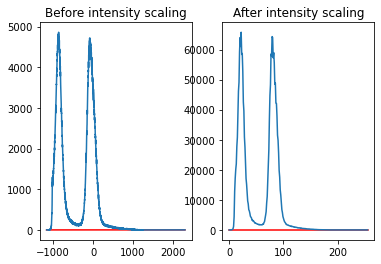

In [37]:
img1 = np.load(glob.glob('d:/Licenta/Train/train_cubes/LNDb-{:04d}_finding{}_rad{}.npy'.format(25,3,3))[0])
img2 = sitk.GetArrayFromImage(rescale_image(sitk.GetImageFromArray(img1)))

'''
Histograms to see the difference before and after intensity scaling
'''

fig, (ax1, ax2) = plt.subplots(1, 2)
hist1, hist_centers1 = skimage.exposure.histogram(img1, nbins=256)
img_cdf1, bins1 = skimage.exposure.cumulative_distribution(img1)
hist2, hist_centers2 = skimage.exposure.histogram(img2, nbins=256)
img_cdf2, bins2 = skimage.exposure.cumulative_distribution(img2)

ax1.plot(bins1, img_cdf1, 'r')
ax1.plot(hist_centers1, hist1)
ax1.set_title("Before intensity scaling")
ax2.plot(bins2, img_cdf2, 'r')
ax2.plot(hist_centers2, hist2)
ax2.set_title("After intensity scaling")

Text(0.5, 1.0, 'After normalization')

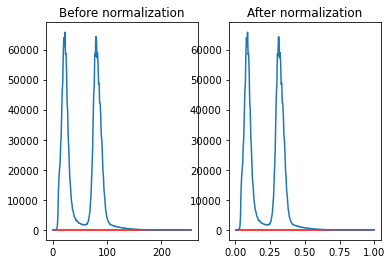

In [38]:
img1 = np.load(glob.glob('d:/Licenta/Train/train_cubes/LNDb-{:04d}_finding{}_rad{}.npy'.format(25,3,3))[0])
img2 = sitk.GetArrayFromImage(rescale_image(sitk.GetImageFromArray(img1)))
img3 = sitk.GetArrayFromImage(min_max_normalization(sitk.GetImageFromArray(img2)))

'''
Histograms to see the difference before and after normalization
'''

fig, (ax1, ax2) = plt.subplots(1, 2)
hist1, hist_centers1 = skimage.exposure.histogram(img2, nbins=256)
img_cdf1, bins1 = skimage.exposure.cumulative_distribution(img2)
hist2, hist_centers2 = skimage.exposure.histogram(img3, nbins=256)
img_cdf2, bins2 = skimage.exposure.cumulative_distribution(img3)

ax1.plot(bins1, img_cdf1, 'r')
ax1.plot(hist_centers1, hist1)
ax1.set_title("Before normalization")
ax2.plot(bins2, img_cdf2, 'r')
ax2.plot(hist_centers2, hist2)
ax2.set_title("After normalization")

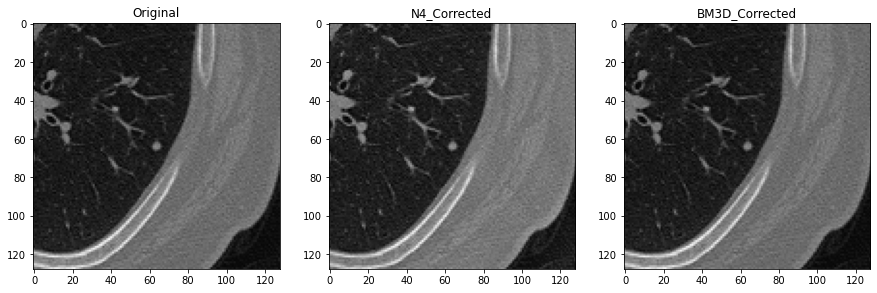

In [43]:
''' The difference between the two bias correction algorithm'''

img_cube = np.load(glob.glob('d:/Licenta/Train/train_cubes/LNDb-{:04d}_finding{}_rad{}.npy'.format(25,3,3))[0])
img_filtered = np.load(glob.glob('d:/Licenta/Train/train_images/LNDb-{:04d}_finding{}_rad{}.npy'.format(25,3,3))[0])
bm3d_img = sitk.GetArrayFromImage(min_max_normalization(rescale_image(sitk.GetImageFromArray(bm3d_bias_correction(img_cube)))))

fig, axs = plt.subplots(1,3, figsize=[15, 15])
axs[0].imshow(img_cube[64], cmap = 'gray')
axs[0].set_title("Original")
axs[1].imshow(img_filtered[64], cmap = 'gray')
axs[1].set_title("N4_Corrected")
axs[2].imshow(bm3d_img[64], cmap = 'gray')
axs[2].set_title("BM3D_Corrected")
plt.show()